# Variational Autoencoding Bayes w/ Tensorflow 

For the computational section of my project, I'll be extending the work in this `tensorflow` tutorial: 

https://www.tensorflow.org/tutorials/generative/cvae

### Data Setup

First, we need to load and preprocess the data. 

In [ ]:
!pip install -q tensorflow-probability
!pip install -q imageio 
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_probability as tfp 

import glob, imageio, PIL, time 
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# only load the mnist images 
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess_images(images): 
  '''Add channel dimension and rescale pixel values to [0, 1] for mnist images.
  Arguments: 
    1. images (tensor) -> images. 
  Returns: 
    2. (tensor) -> preprocessed images.'''

  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0 
  return np.where(images>0.5, 1.0, 0.0).astype('float32')

# preprocess mnist images 
train_images = preprocess_images(train_images) 
test_images = preprocess_images(test_images)

In [ ]:
# hyperparameters 
train_size = 40000 
batch_size = 32 
test_size = 10000 

In [ ]:
# shuffle and batch data 
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

### Encoder/Decoder Models 

We'll use convolutional networks to represent our encoder and decoder - $q_\phi(z|x)$ and $p_\theta(x|z)$ respectively. Our encoder network will consist of two convolutional layers and a fully-connected layer. The convolutions will work to shrink the dimension of an input image into our latent space. Our decoder network will consist of one fully-connected layer and three deconvolutional layers. The deconvolutional layers work to upscale an input, so they will increase the dimension of a latent variable into an image. 

In [ ]:
class CVAE(tf.keras.Model): 
  '''Variational autoencoder.'''

  def __init__(self, latent_dim): 
    super(CVAE, self).__init__() 
    self.latent_dim = latent_dim 

    # encoder model 
    # conv -> conv -> dense 
    self.encoder = tf.keras.Sequential([
                                        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                                        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'), 
                                        tf.keras.layers.Flatten(), 
                                        tf.keras.layers.Dense(latent_dim+latent_dim)
    ])

    # decoder model 
    # dense -> deconv -> deconv -> deconv 
    self.decoder = tf.keras.Sequential([
                                        tf.keras.layers.InputLayer(input_shape=(latent_dim,)), 
                                        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu), 
                                        tf.keras.layers.Reshape(target_shape=(7, 7, 32)), 
                                        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'), 
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), 
                                        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
    ])

  @tf.function 
  def sample(self, eps=None): 
    '''Decode latent variable. 
    Arguments: 
      1. eps=None (vector) -> epsilons for the reparameterization trick. if not supplied, random normal eps is generated.
    Returns:
      1. (tensor) -> decoded images.'''

    if eps is None: 
      eps = tf.random.normal(shape=(100, self.latent_dim)) 
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x): 
    '''Encode images. 
    Arguments: 
      1. x (tensor) -> images. 
    Returns: 
      1. mean (vector) -> mean latent representation.
      2. logvar (vector) -> log variance of latent representation.'''

    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1) 
    return mean, logvar

  def reparameterize(self, mean, logvar):
    '''Generate realization of latent variable. 
    Arguments: 
      1. mean (vector) -> mean latent representation. 
      2. logvar (vector) -> log variance of latent representation. 
    Returns: 
      1. (vector) -> random realization of the latent variable.''' 

    eps = tf.random.normal(shape=mean.shape) 
    return eps * tf.exp(logvar*0.5) + mean

  def decode(self, z, apply_sigmoid=False): 
    '''Get decoder logits. 
    Arguments: 
      1. z (vector) -> latent variable. 
      2. apply_sigmoid=False (bool) -> if true, return probabilities. if false, return logits.
    Returns: 
      1. logits/probs (tensor) -> decoder output.'''
      
    logits = self.decoder(z) 
    if apply_sigmoid: 
      probs = tf.sigmoid(logits) 
      return probs 
    return logits 

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4) 

def log_normal_pdf(sample, mean, logvar, raxis=1): 
  '''Log of normal density. 
  Arguments:  
    1. sample (matrix) -> realizations. 
    2. mean (vector) -> normal mean. 
    3. logvar (vector) -> log of normal variance. 
    4. raxis=1 (int) -> axis to sum over. 
  Returns: 
    1. (vector) -> log density.'''

  log2pi = tf.math.log(2.0*np.pi) 
  return tf.reduce_sum(-0.5*((sample-mean)**2 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x): 
  '''Reconstruction loss. 
  Arguments: 
    1. model (CAVE) -> variation autoencoder. 
    2. x (tensor) -> image. 
  Returns: 
    1. image reconstruction loss using model.'''

  # reconstruct image 
  mean, logvar = model.encode(x) 
  z = model.reparameterize(mean, logvar) 
  x_logit = model.decode(z) 

  # calculate reconstruction loss 
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) 
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) 
  logpz = log_normal_pdf(z, 0., 0.) 
  logqz_x = log_normal_pdf(z, mean, logvar)

  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function 
def train_step(model, x, optimizer): 
  '''CVAE optimization step. 
  Arguments: 
    1. model (CVAE) -> variational autoencoder. 
    2. x (tensor) -> images. 
    3. optimizer (keras.optimizer) -> optimizer algorithm. 
  Returns: 
    None'''

  # compute batch loss 
  with tf.GradientTape() as tape: 
    loss = compute_loss(model, x) 

  # optimization step
  gradients = tape.gradient(loss, model.trainable_variables) 
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
# training hyperparameters 
epochs = 10 
latent_dim = 2 
num_examples_to_generate = 16 

# constant epsilon vector 
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim]) 

# model instance
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample): 
  '''Plot and save predictions as png.
  Arguments: 
    1. model (CVAE) -> variational autoencoder. 
    2. epoch (int) -> current epoch. 
    3. test_sample (tensor) -> images. 
  Returns: 
    1. None'''

  # predict on test images  
  mean, logvar = model.encode(test_sample) 
  z = model.reparameterize(mean, logvar) 
  predictions = model.sample(z) 
  fig = plt.figure(figsize=(4, 4)) 

  # plot predictions 
  for i in range(predictions.shape[0]): 
    plt.subplot(4, 4, i+1) 
    plt.imshow(predictions[i, :, :, 0], cmap='gray') 
    plt.axis('off') 
  
  # save predictions 
  save_path = '/content/gdrive/MyDrive/'
  plt.savefig(save_path+'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# test sample 
assert batch_size >= num_examples_to_generate 
for test_batch in test_dataset.take(1): 
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.4866943359375, time elapse for current epoch: 97.5661883354187


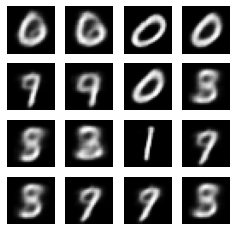

In [ ]:
# predictors for randomly initialized model 
generate_and_save_images(model, 0, test_sample) 

# training procedure 
for epoch in range(1, epochs+1): 

  # time optimization step 
  start_time = time.time() 
  for train_x in train_dataset: 
    train_step(model, train_x, optimizer) 
  end_time = time.time() 

  # track model metrics 
  loss = tf.keras.metrics.Mean() 
  for test_x in test_dataset: 
    loss(compute_loss(model, test_x)) 
  elbo = -loss.result() 

  # display metrics and train time 
  display.clear_output(wait=False) 
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time-start_time))
  generate_and_save_images(model, epoch, test_sample)

### Model Inference

Now that we have a fitted model, we can use visualizations to see what it's learned. 

In [ ]:
def display_image(epoch_no): 
  '''Display generated images from an epoch of training.
  Arguments: 
    1. epoch_no (int) -> epoch. 
  Returns: 
    1. (PIL.Image) -> generated images.'''
    
  save_path = '/content/gdrive/MyDrive/'
  return PIL.Image.open(save_path+'image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
anim_file = 'cvae.gif' 
save_path = '/content/gdrive/MyDrive/'

# create GIF of generated images over epochs 
with imageio.get_writer(anim_file, mode='I') as writer: 

  # generated images 
  filenames = glob.glob(save_path+'image*.png') 
  filenames = sorted(filenames) 

  # build GIF 
  for filename in filenames: 
    image = imageio.imread(filename) 
    writer.append_data(image) 
  image = imageio.imread(filename) 
  writer.append_data(image) 


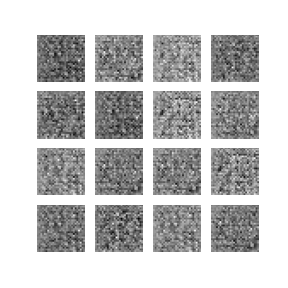

In [ ]:
# create GIF 
import tensorflow_docs.vis.embed as embed 
embed.embed_file(anim_file)

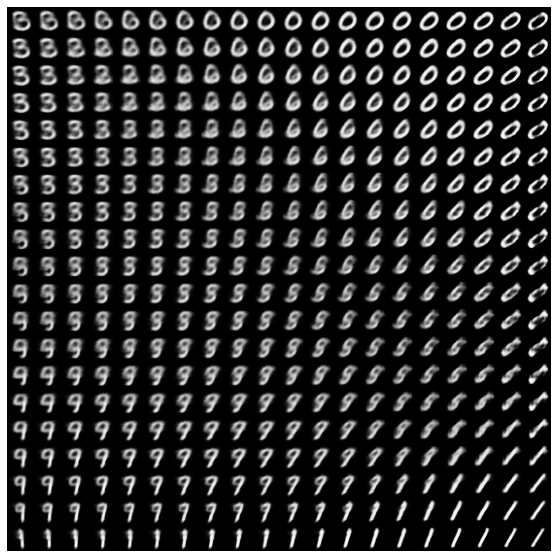

In [ ]:
def plot_latent_images(model, n, digit_size=28): 
  '''2D manifold of digits from the latent space.
  Arguments: 
    1. model (CVAE) -> variational autoencoder. 
    2. n (int) -> dimension of manifold. 
    3. digit_size=28 (int) -> image resolution.
  Return: 
    1. None'''

  # grid space of latent variables 
  norm = tfp.distributions.Normal(0, 1) 
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n)) 
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n)) 
  image_width = digit_size*n 
  image_height = image_width 
  image = np.zeros((image_height, image_width)) 

  # decode latent variables 
  for i, yi in enumerate(grid_x): 
    for j, xi in enumerate(grid_y): 
      z = np.array([[xi, yi]]) 
      x_decoded = model.sample(z) 
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size)) 
      image[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit.numpy() 

  # plot decoded images 
  plt.figure(figsize=(10, 10)) 
  plt.imshow(image, cmap='Greys_r') 
  plt.axis('Off') 
  plt.show()

plot_latent_images(model, 20)

The following function is modified from a different notebook on VAEs: 

https://keras.io/examples/generative/vae/

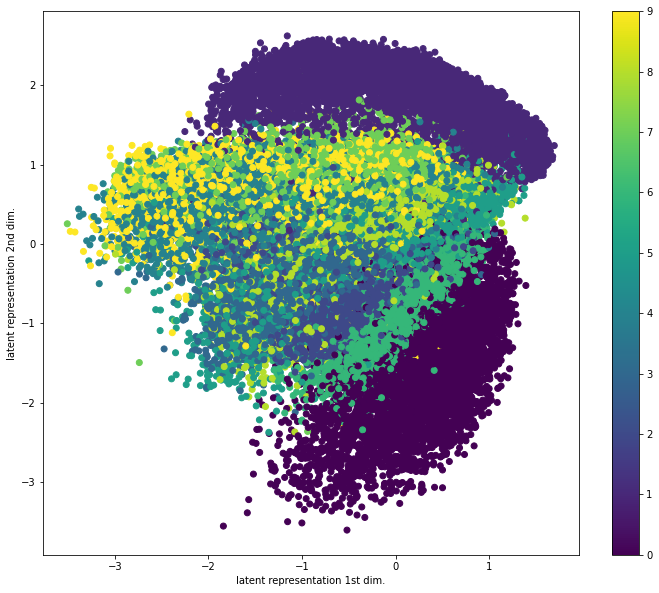

In [ ]:
def plot_label_clusters(model, data, labels): 
  '''Plot latent distribution of data and color code labels.
  Arguments:  
    1. model (CVAE) -> variational autoencoder. 
    2. data (tensor) -> images. 
    3. labels (vector) -> associated image labels.
  Returns: 
    1. None'''

  # encode data 
  mean, _ = model.encode(data) 
  plt.figure(figsize=(12, 10)) 

  # plot latent representations
  # color labels 
  plt.scatter(mean[:,0], mean[:,1], c=labels) 
  plt.colorbar() 
  plt.xlabel('latent representation 1st dim.') 
  plt.ylabel('latent representation 2nd dim.')
  plt.show() 

# plot training data 
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data() 
x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0 
plot_label_clusters(model, x_train, y_train)